# Assignment 2: Filtering and edge detection
Quick notebook to run Gaussian smoothing, gradient magnitude, Laplacian-of-Gaussian (DoG), and Canny edge detection on `mandrill.jpg`. Adjust parameters as needed and re-run cells.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['image.cmap'] = 'gray'

# Read grayscale image
img_path = 'mandrill.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f'Could not read {img_path}. Place the image next to this notebook.')
print('Image shape:', img.shape, 'dtype:', img.dtype)


FileNotFoundError: Could not read mandrill.jpg. Place the image next to this notebook.

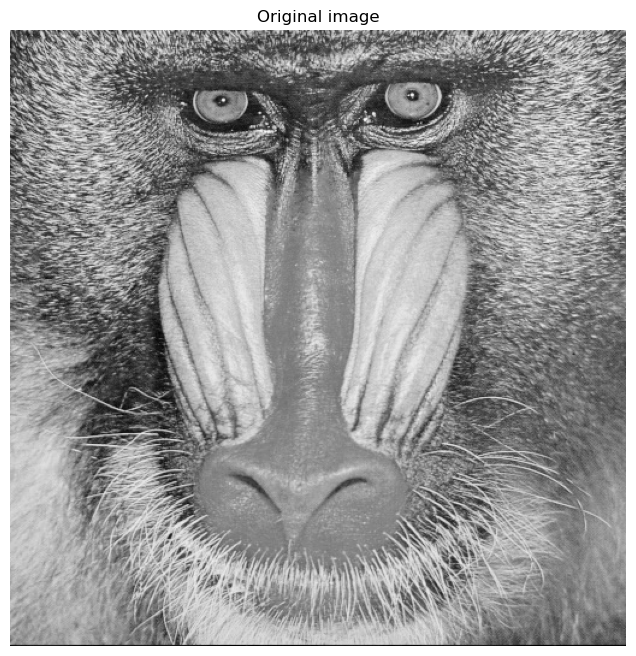

In [17]:
# Show original image
plt.imshow(img)
plt.title('Original image')
plt.axis('off')
plt.show()


### Kommentar til originalbillede
Sikrer at billedet er læst korrekt. Brug dette som reference naar du sammenligner filtrerede resultater.


## Gaussian smoothing
Smoothing with different sigma values; kernel size chosen automatically by OpenCV (truncated).


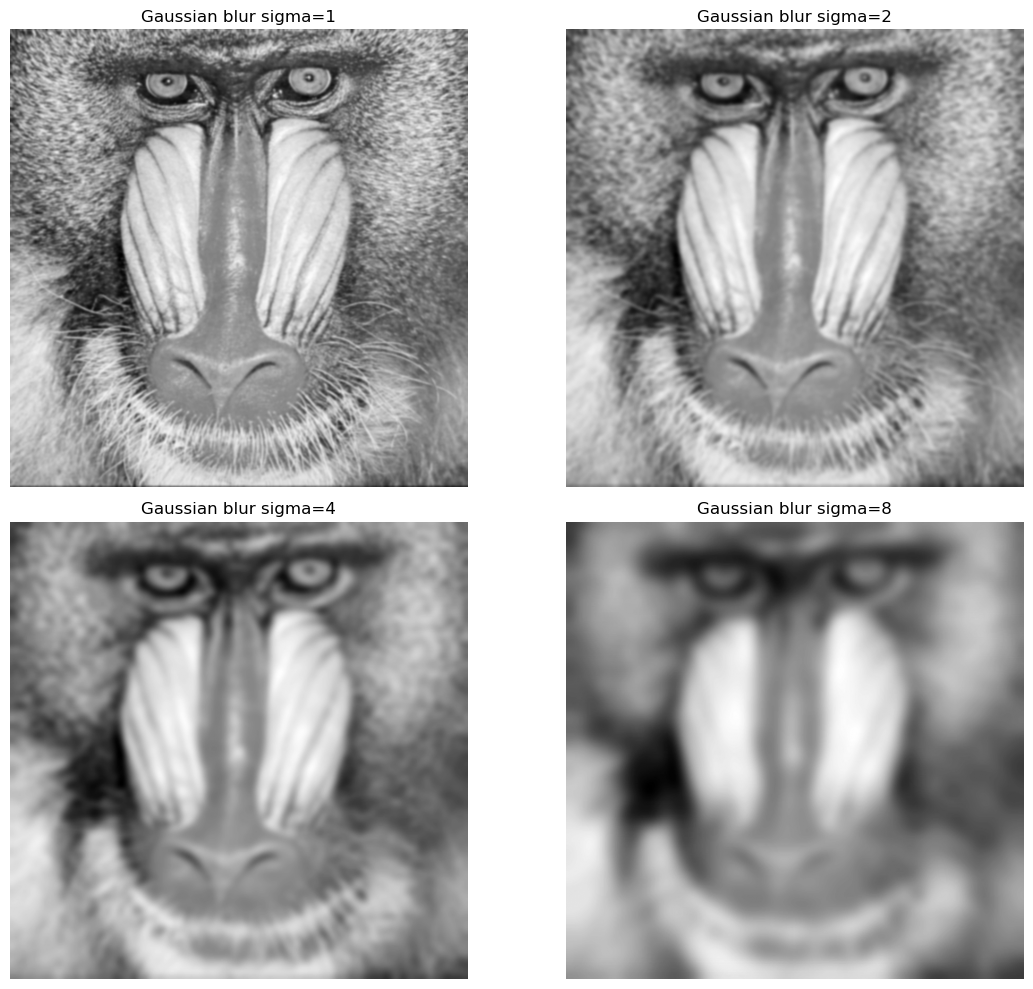

In [18]:
sigmas = [1, 2, 4, 8]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, sigma in zip(axes.ravel(), sigmas):
    blurred = cv2.GaussianBlur(img, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)
    ax.imshow(blurred)
    ax.set_title(f'Gaussian blur sigma={sigma}')
    ax.axis('off')
plt.tight_layout()
plt.show()


### Fortolkning af Gaussisk glatning
- sigma=1: Lidt glatning, kanter bevares rimeligt.
- sigma=2: Mere glatning, fine strukturer (pels) bliver mindre tydelige.
- sigma=4: Store strukturer bevares, mindre detaljer bliver slaaet sammen.
- sigma=8: Meget kraftig glatning, billedet ser udvisket ud og kun grove konturer staar tilbage.
Brug disse observationer i rapporten til at forklare forholdet mellem sigma og detaljetab.


## Gradient magnitude via Gaussian derivatives
Gaussian smooth first, then compute Sobel derivatives and magnitude.


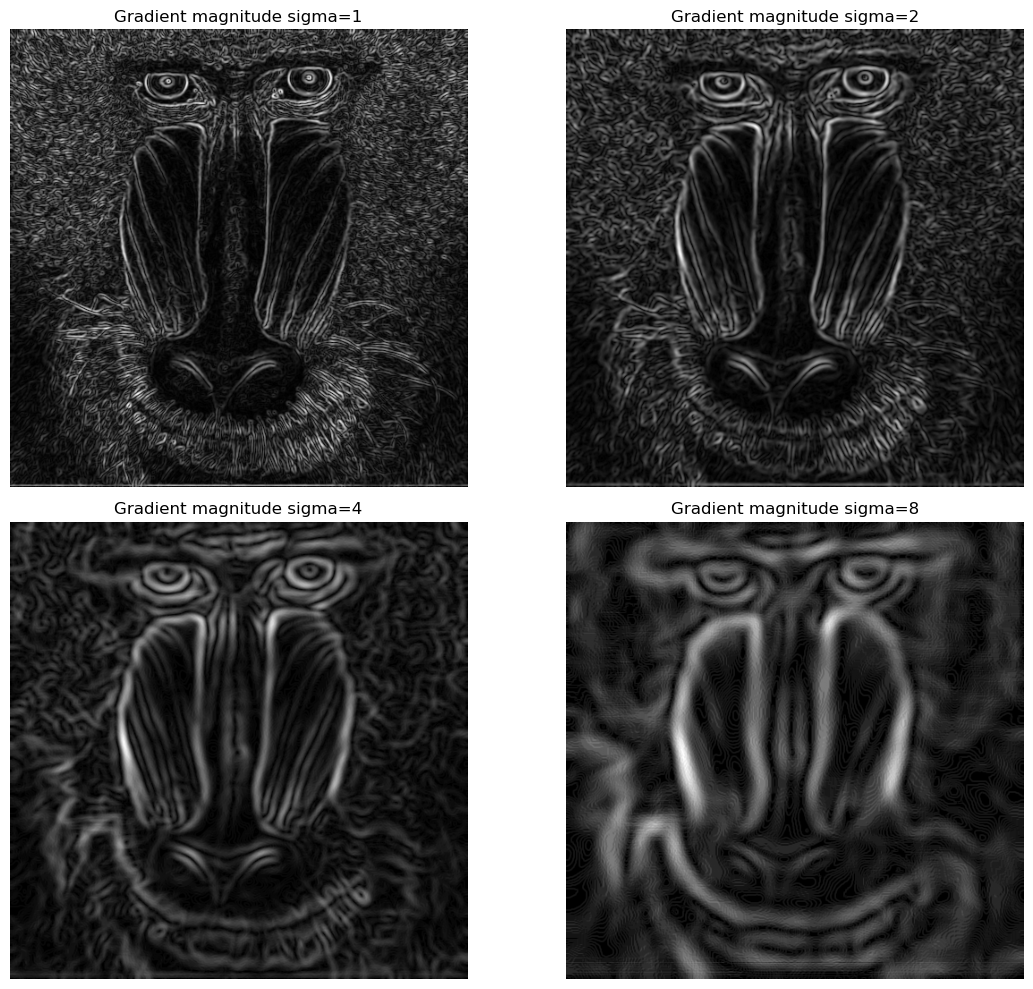

In [19]:
def gradient_magnitude(gray, sigma):
    blurred = cv2.GaussianBlur(gray, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)
    dx = cv2.Sobel(blurred, cv2.CV_32F, 1, 0, ksize=3)
    dy = cv2.Sobel(blurred, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(dx ** 2 + dy ** 2)
    mag = cv2.normalize(mag, None, 0, 1, cv2.NORM_MINMAX)
    return mag

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, sigma in zip(axes.ravel(), sigmas):
    mag = gradient_magnitude(img, sigma)
    ax.imshow(mag, cmap='gray')
    ax.set_title(f'Gradient magnitude sigma={sigma}')
    ax.axis('off')
plt.tight_layout()
plt.show()


### Fortolkning af gradientmagnituder
- Lille sigma (1): Mange skarpe kanter, men ogsaa stoej fra tekstur.
- Stoerre sigma (2-4): Stoej reduceres, kanter bliver mere sammenhaengende; svagere kanter kan dog blive mindre tydelige.
- Meget stor sigma (8): Kun grove kanter staar tilbage, fine detaljer forsvinder.
Naevn i rapporten hvordan glatning foer derivat reducerer stoej men kan udviske fine kanter.


## Laplacian of Gaussian (Difference of Gaussians)
Approximate LoG using DoG with a wider second sigma (ratio 1.6). Values are rescaled for display.


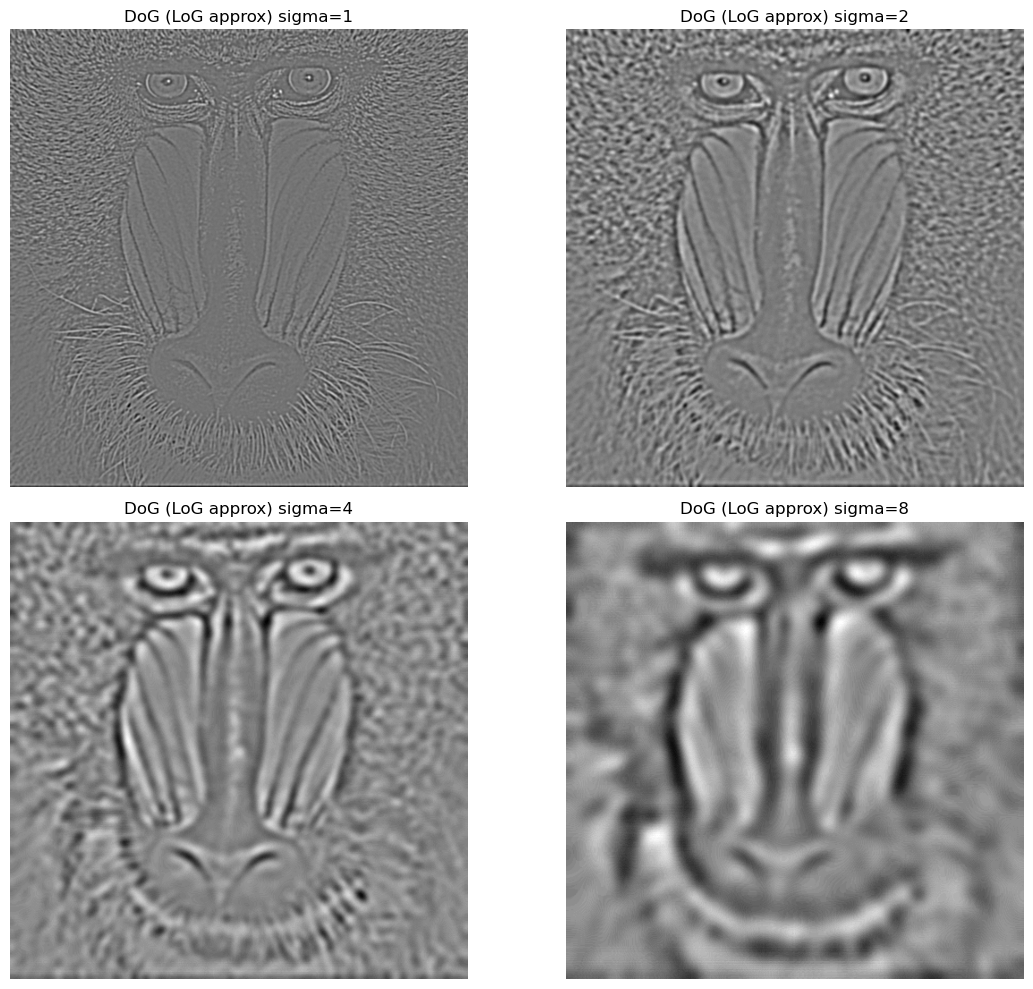

In [20]:
def difference_of_gaussians(gray, sigma, ratio=1.6):
    g1 = cv2.GaussianBlur(gray, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)
    g2 = cv2.GaussianBlur(gray, ksize=(0, 0), sigmaX=sigma * ratio, sigmaY=sigma * ratio)
    dog = g1.astype(np.float32) - g2.astype(np.float32)
    dog_disp = cv2.normalize(dog, None, 0, 1, cv2.NORM_MINMAX)
    return dog_disp

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, sigma in zip(axes.ravel(), sigmas):
    dog = difference_of_gaussians(img, sigma)
    ax.imshow(dog, cmap='gray')
    ax.set_title(f'DoG (LoG approx) sigma={sigma}')
    ax.axis('off')
plt.tight_layout()
plt.show()


### Fortolkning af DoG / LoG
- Positive/negative omraader markerer hurtige intensitets-skift; nul-kryds svarer til kanter eller blobs.
- Lille sigma finder smaa blobs/kanter, stoerre sigma finder kun store strukturer.
- Ratio=1.6 er en almindelig SIFT-inspireret vaerdi; juster hvis du vil separere skalaer anderledes.
I rapporten: kommenter hvordan kontrasten i DoG-billedet aendrer sig med sigma, og hvor blobs/kanter fremtraeder.


## Canny edge detection
Tune thresholds to balance noise suppression and edge continuity.


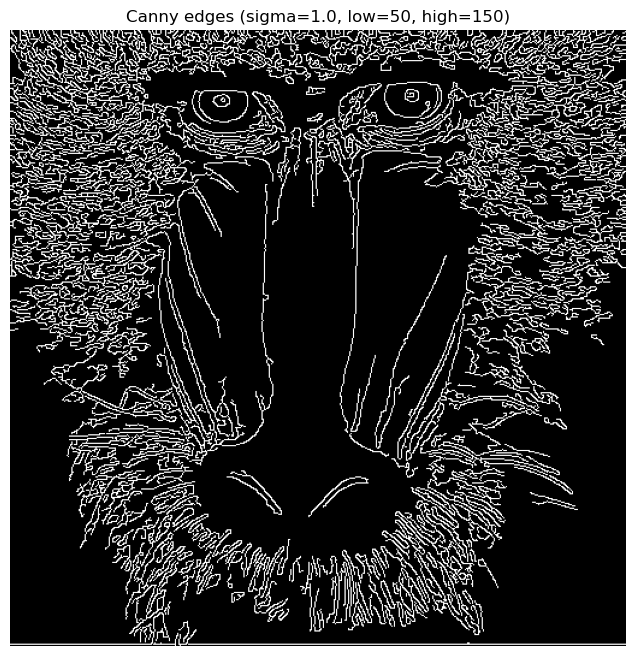

In [21]:
canny_sigma = 1.0
low_thresh = 50
high_thresh = 150
blurred = cv2.GaussianBlur(img, ksize=(0, 0), sigmaX=canny_sigma, sigmaY=canny_sigma)
edges = cv2.Canny(blurred, threshold1=low_thresh, threshold2=high_thresh, apertureSize=3, L2gradient=True)

plt.figure(figsize=(10, 8))
plt.imshow(edges, cmap='gray')
plt.title(f'Canny edges (sigma={canny_sigma}, low={low_thresh}, high={high_thresh})')
plt.axis('off')
plt.show()


### Fortolkning af Canny-parametre
- sigma (gaussian blur foer Canny): styrer stoejreduktion; stoerre sigma giver glattere, men bredere kanter.
- low/high thresholds: lavere vaerdier giver flere/svagere kanter og mere stoej; hoejere vaerdier giver faerre men renere kanter.
- apertureSize=3 og L2gradient=True bruger en mere praecis gradientnorm (Euklidisk).
Test evt. flere threshold-saet og vis det bedste i rapporten. Forklar valg og effekt paa sammenhaeng/tydelighed.
